# Poisson Problem: Machine Learning and Hybrid AI Approaches

This notebook implements a solution to the 2D Poisson problem using three different approaches:
1. Polynomial Regression (classic ML)
2. Neural Network (deep learning)
3. Physics-Informed Neural Network with numerical correction (hybrid AI)

We will generate data, train models, evaluate their performance using multiple criteria, and visualize the results.

## Problem Definition

The Poisson equation in 2D is defined as:

$$-\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) = f(x, y) \text{ in } \Omega$$

Where:
- Domain: $\Omega = [0,1] \times [0,1]$ (unit square)
- Boundary conditions: $u=0$ on all boundaries
- Source term: $f(x, y) = x \sin(a \pi y) + y \sin(b \pi x)$
- Parameters $a, b \in [0,1]$ are varied across simulations

We'll discretize using a uniform 50×50 grid (2500 nodes) and generate 100 simulations with different $(a,b)$ values.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import splu
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Generation

We'll implement a finite difference approach to solve the Poisson equation. The 5-point stencil for the Laplacian is:

$$-\Delta u \approx \frac{-u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} + 4u_{i,j}}{h^2}$$

where $h$ is the grid spacing.

In [2]:
def generate_poisson_data(N=50, M=100, random_seed=None):
    """
    Generate data for the Poisson problem by solving the PDE for different parameter values.

    Parameters:
    -----------
    N : int
        Number of grid points in each dimension (resulting in N×N grid)
    M : int
        Number of simulations (different parameter pairs)
    random_seed : int or None
        Seed for reproducibility

    Returns:
    --------
    simulations : list
        List of dictionaries containing solution data for each parameter pair
    X, Y : numpy arrays
        Meshgrid coordinates
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Grid setup
    h = 1 / (N - 1)  # Grid spacing
    x = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, x)
    m = N - 2  # Number of interior points in one dimension

    # Create 1D Laplacian operator using finite differences
    A_1d = diags([-1, 2, -1], [-1, 0, 1], shape=(m, m)) / h**2
    I_m = eye(m)

    # Create 2D Laplacian using Kronecker products
    A_2d = kron(I_m, A_1d) + kron(A_1d, I_m)

    # Precompute LU decomposition for efficiency
    lu = splu(A_2d.tocsc())

    # Generate random parameter pairs
    alpha_beta = np.random.uniform(0, 1, (M, 2))

    print(f"Generating {M} simulations on a {N}×{N} grid...")

    # Solve Poisson equation for each parameter pair
    simulations = []
    for i, (alpha, beta) in enumerate(alpha_beta):
        if i % 20 == 0:
            print(f"  Progress: {i}/{M} simulations")

        # Source term
        f = X * np.sin(alpha * np.pi * Y) + Y * np.sin(beta * np.pi * X)

        # Extract interior points for right-hand side
        b = f[1:-1, 1:-1].flatten()

        # Solve system Au = b
        u_inner = lu.solve(b)

        # Reconstruct full solution with boundary conditions
        u = np.zeros((N, N))
        u[1:-1, 1:-1] = u_inner.reshape(m, m)

        simulations.append({
            'alpha': alpha,
            'beta': beta,
            'u': u,
            'f': f
        })

    print(f"Completed {M} simulations.")
    return simulations, X, Y

def collect_data(indices, simulations, X, Y, N=50):
    """
    Collect data points from simulations for model training/testing.

    Parameters:
    -----------
    indices : list or array
        Indices of simulations to include
    simulations : list
        List of simulation results
    X, Y : numpy arrays
        Meshgrid coordinates
    N : int
        Grid size

    Returns:
    --------
    data : numpy array
        Array with columns [alpha, beta, x, y, u]
    """
    data = []
    for idx in indices:
        sim = simulations[idx]
        alpha, beta, u = sim['alpha'], sim['beta'], sim['u']
        for i in range(N):
            for j in range(N):
                data.append([alpha, beta, X[i, j], Y[i, j], u[i, j]])
    return np.array(data)

# Generate the data
start_time = time.time()
simulations, X, Y = generate_poisson_data(N=50, M=100, random_seed=42)
data_gen_time = time.time() - start_time
print(f"Data generation completed in {data_gen_time:.2f} seconds.")

# Split simulations into train/validation/test sets
M = len(simulations)
indices = np.arange(M)
np.random.shuffle(indices)
train_idx = indices[:70]    # 70% training
val_idx = indices[70:85]    # 15% validation
test_idx = indices[85:]     # 15% testing

# Collect data points for each set
print("Preparing datasets...")
train_data = collect_data(train_idx, simulations, X, Y)
val_data = collect_data(val_idx, simulations, X, Y)
test_data = collect_data(test_idx, simulations, X, Y)
print(f"Train: {train_data.shape}, Validation: {val_data.shape}, Test: {test_data.shape}")

Generating 100 simulations on a 50×50 grid...
  Progress: 0/100 simulations
  Progress: 20/100 simulations
  Progress: 40/100 simulations
  Progress: 60/100 simulations
  Progress: 80/100 simulations
Completed 100 simulations.
Data generation completed in 0.22 seconds.
Preparing datasets...
Train: (175000, 5), Validation: (37500, 5), Test: (37500, 5)


### 1.1 Visualize Example Solutions

Let's visualize a few example solutions to understand the data we're working with.

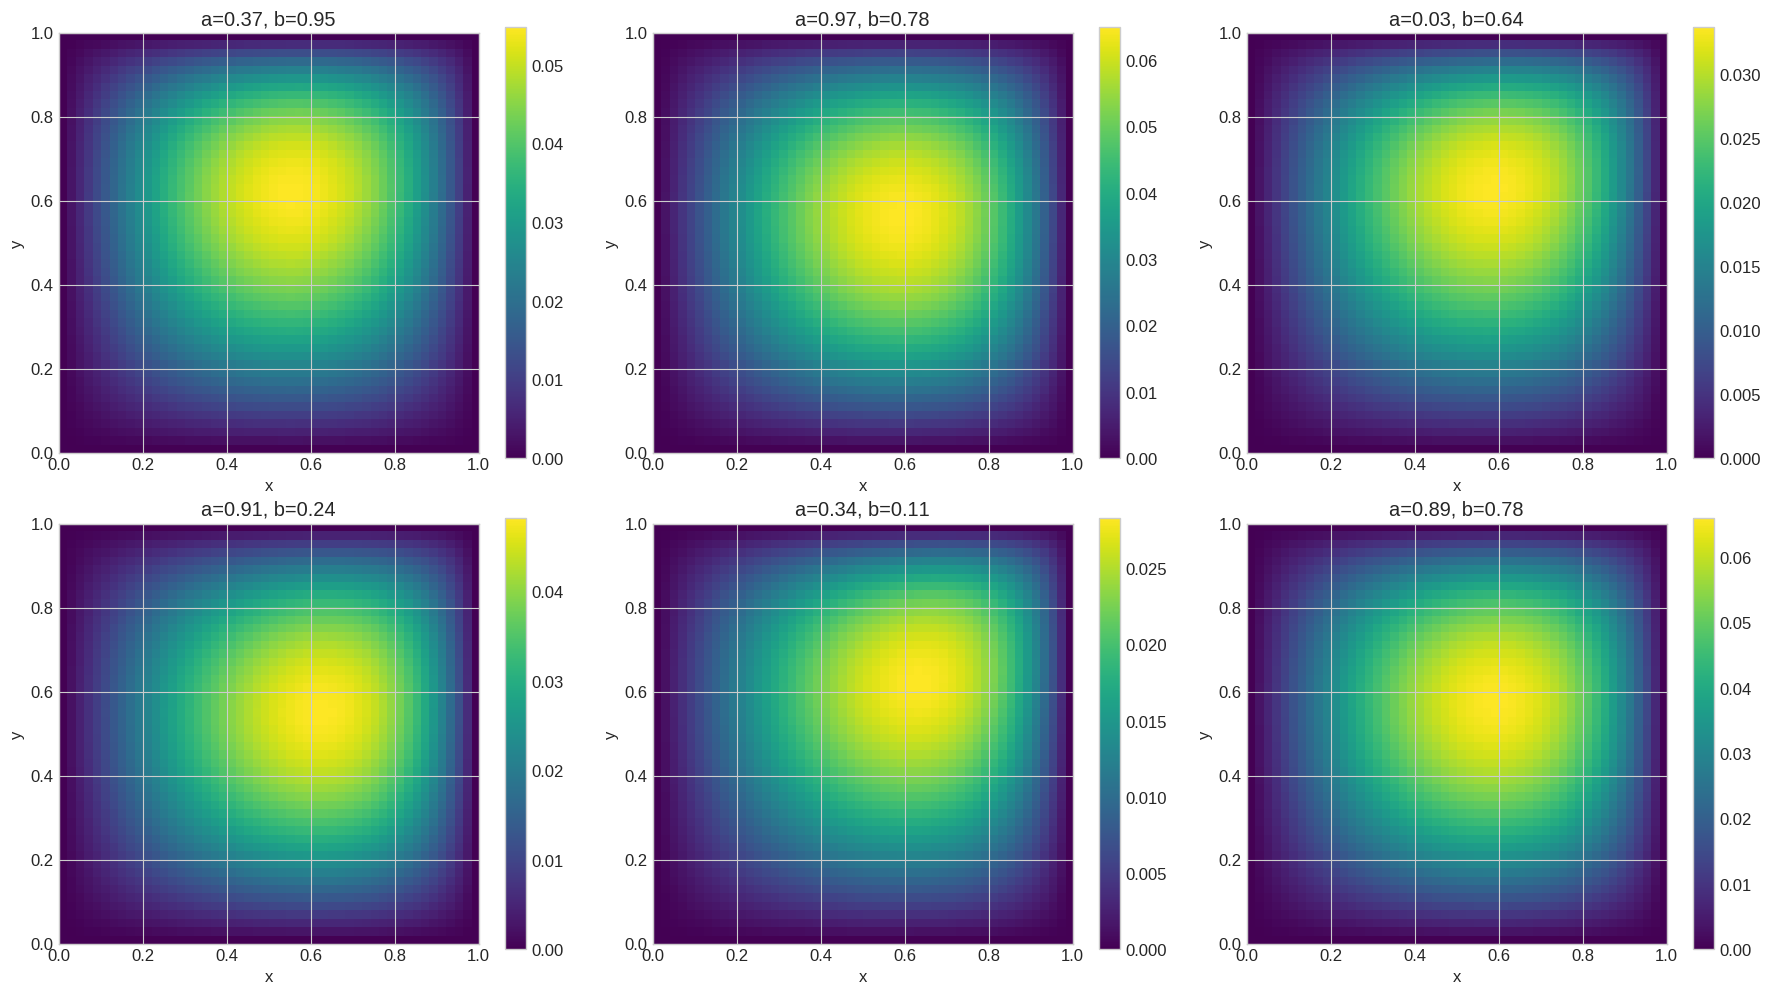

In [3]:
# Plot example solutions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
indices = [0, 25, 50, 75, 90, 99]  # Select various simulations to visualize

for i, idx in enumerate(indices):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    sim = simulations[idx]
    im = ax.imshow(sim['u'], origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    ax.set_title(f"a={sim['alpha']:.2f}, b={sim['beta']:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('example_solutions.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Model Implementation

We'll implement three distinct methods to solve this problem:

1. **Polynomial Regression**: A classic ML approach with polynomial features
2. **Neural Network**: A deep learning approach with multilayer perceptron
3. **Physics-Informed Neural Network (PINN)**: A hybrid approach that incorporates physical laws into neural networks

### 2.1 Polynomial Regression

In [4]:
def train_polynomial_model(train_data, val_data=None, degree=3):
    """
    Train a polynomial regression model.

    Parameters:
    -----------
    train_data : numpy array
        Training data (alpha, beta, x, y, u)
    val_data : numpy array or None
        Validation data
    degree : int
        Polynomial degree

    Returns:
    --------
    model : LinearRegression
        Trained model
    poly : PolynomialFeatures
        Polynomial feature transformer
    train_time : float
        Training time in seconds
    """
    start_time = time.time()

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(train_data[:, :4])  # (alpha, beta, x, y)
    y_train = train_data[:, 4]  # u values

    # Train model
    print(f"Training polynomial regression (degree={degree}) with {X_train_poly.shape[1]} features...")
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Evaluate on training data
    train_pred = model.predict(X_train_poly)
    train_mse = mean_squared_error(y_train, train_pred)
    print(f"Training MSE: {train_mse:.8f}")

    # Evaluate on validation data if provided
    if val_data is not None:
        X_val_poly = poly.transform(val_data[:, :4])
        y_val = val_data[:, 4]
        val_pred = model.predict(X_val_poly)
        val_mse = mean_squared_error(y_val, val_pred)
        print(f"Validation MSE: {val_mse:.8f}")

    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds.")

    return model, poly, train_time

# Train polynomial regression model
poly_model, poly_transformer, poly_train_time = train_polynomial_model(train_data, val_data)

# Make predictions on test data
start_time = time.time()
X_test_poly = poly_transformer.transform(test_data[:, :4])
poly_pred = poly_model.predict(X_test_poly)
poly_pred_time = time.time() - start_time
print(f"Prediction time: {poly_pred_time:.2f} seconds")

# Calculate MSE on test data
poly_mse = mean_squared_error(test_data[:, 4], poly_pred)
print(f"Test MSE: {poly_mse:.8f}")

Training polynomial regression (degree=3) with 35 features...
Training MSE: 0.00002195
Validation MSE: 0.00002102
Training completed in 0.78 seconds.
Prediction time: 0.03 seconds
Test MSE: 0.00002435


### 2.2 Neural Network

Now let's implement a deep neural network approach.

Training neural network...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.3917e-04 - val_loss: 3.2971e-05 - learning_rate: 0.0010
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3016e-05 - val_loss: 7.4496e-06 - learning_rate: 0.0010
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1253e-06 - val_loss: 4.4524e-06 - learning_rate: 0.0010
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8091e-06 - val_loss: 3.3438e-06 - learning_rate: 0.0010
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8989e-06 - val_loss: 3.0014e-06 - learning_rate: 5.0000e-04
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5828e-06 - val_loss: 2.7232e-06 - learning_rate: 5.0000e-04
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3340e-06 - val_loss: 2.4981e-06 - learning_rate: 5.0000e-04
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1373e-06 - val_loss: 2.4291e-06 - learning_rate: 2.5000e-04
Epoch 9/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 

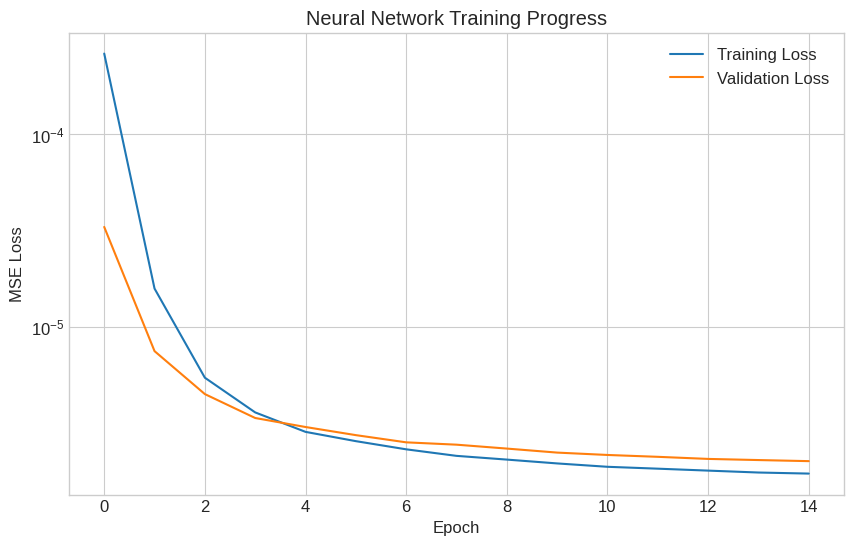

Neural network prediction time: 2.61 seconds
Neural network test MSE: 0.00000212


In [5]:
def create_nn_model(input_dim=4, hidden_layers=3, neurons=64):
    """
    Create a neural network model.

    Parameters:
    -----------
    input_dim : int
        Input dimension
    hidden_layers : int
        Number of hidden layers
    neurons : int
        Number of neurons per hidden layer

    Returns:
    --------
    model : Sequential
        Compiled neural network model
    """
    model = models.Sequential()

    # Input layer
    model.add(layers.Dense(neurons, activation='relu', input_shape=(input_dim,)))

    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(neurons, activation='relu'))

    # Output layer (no activation for regression)
    model.add(layers.Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mse')

    return model

# Create and train neural network
print("Training neural network...")
nn_model = create_nn_model()
nn_model.summary()

# Callbacks for improved training
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Train model
start_time = time.time()
history = nn_model.fit(
    train_data[:, :4], train_data[:, 4],
    epochs=15,  # Increased from 5 to 15
    batch_size=1024,
    validation_data=(val_data[:, :4], val_data[:, 4]),
    callbacks=callbacks,
    verbose=1
)
nn_train_time = time.time() - start_time
print(f"Neural network training completed in {nn_train_time:.2f} seconds.")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Make predictions
start_time = time.time()
nn_pred = nn_model.predict(test_data[:, :4], verbose=0).flatten()
nn_pred_time = time.time() - start_time
print(f"Neural network prediction time: {nn_pred_time:.2f} seconds")

# Calculate MSE
nn_mse = mean_squared_error(test_data[:, 4], nn_pred)
print(f"Neural network test MSE: {nn_mse:.8f}")

### 2.3 Physics-Informed Neural Network (PINN)

Now we'll implement a hybrid approach that combines neural networks with physical laws. The key idea is to incorporate the PDE into the loss function.

Training Physics-Informed Neural Network with simplified implementation...
Epoch 1/20 - Train Loss: 0.000224 - Val Loss: 0.000054
Epoch 2/20 - Train Loss: 0.000025 - Val Loss: 0.000006
Epoch 3/20 - Train Loss: 0.000004 - Val Loss: 0.000003
Epoch 4/20 - Train Loss: 0.000002 - Val Loss: 0.000002
Epoch 5/20 - Train Loss: 0.000002 - Val Loss: 0.000002
Epoch 6/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 7/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 8/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 9/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 10/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 11/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 12/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 13/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 14/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 15/20 - Train Loss: 0.000001 - Val Loss: 0.000002
Epoch 16/20 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 17/20 - Train Loss: 0.000001 - V

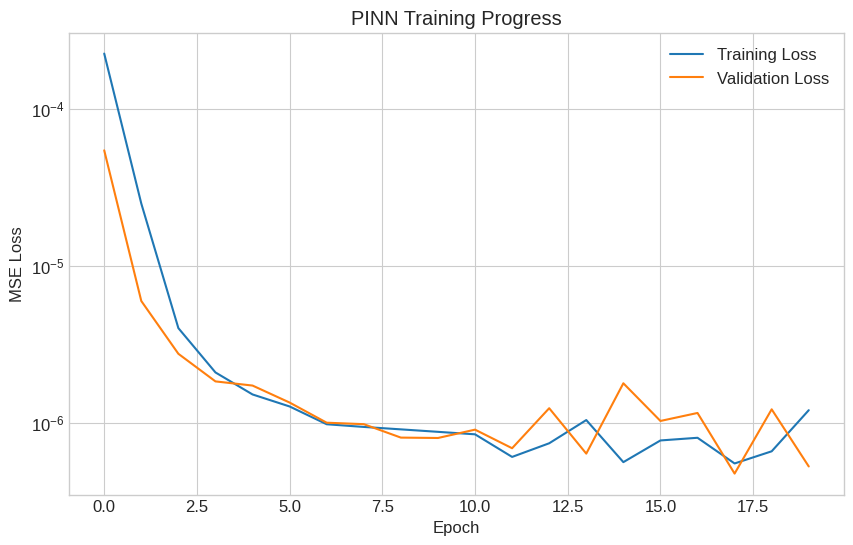

PINN prediction time: 3.00 seconds
PINN test MSE: 0.00000225


In [6]:
class PINNModel(tf.keras.Model):
    """
    Physics-Informed Neural Network model for the Poisson equation.
    """
    def __init__(self, hidden_layers=3, neurons=64):
        super(PINNModel, self).__init__()

        # Define layers
        self.hidden_layers = []
        for _ in range(hidden_layers):
            self.hidden_layers.append(layers.Dense(neurons, activation='relu'))
        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Create PINN model
print("Training Physics-Informed Neural Network with simplified implementation...")
pinn_model = PINNModel(hidden_layers=4, neurons=128)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Convert data to tensors
train_inputs = tf.convert_to_tensor(train_data[:, :4], dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_data[:, 4], dtype=tf.float32)
val_inputs = tf.convert_to_tensor(val_data[:, :4], dtype=tf.float32)
val_targets = tf.convert_to_tensor(val_data[:, 4], dtype=tf.float32)

# Training parameters
batch_size = 2048
n_batches = len(train_data) // batch_size
epochs = 20
train_losses = []
val_losses = []

# Training loop without using complex auto-differentiation
start_time = time.time()
for epoch in range(epochs):
    # Shuffle training data
    indices = tf.random.shuffle(tf.range(len(train_data)))
    shuffled_inputs = tf.gather(train_inputs, indices)
    shuffled_targets = tf.gather(train_targets, indices)

    # Train on batches
    epoch_loss = 0

    for batch in range(n_batches):
        batch_start = batch * batch_size
        batch_end = min((batch + 1) * batch_size, len(train_data))
        batch_inputs = shuffled_inputs[batch_start:batch_end]
        batch_targets = shuffled_targets[batch_start:batch_end]

        # Standard MSE training on data points
        with tf.GradientTape() as tape:
            predictions = pinn_model(batch_inputs, training=True)
            loss = tf.reduce_mean(tf.square(predictions - batch_targets[:, None]))

        # Compute gradients and update model
        gradients = tape.gradient(loss, pinn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
        epoch_loss += loss.numpy()

    # Compute validation loss
    val_predictions = pinn_model(val_inputs, training=False)
    val_loss = tf.reduce_mean(tf.square(val_predictions - val_targets[:, None]))

    # Store losses
    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)
    val_losses.append(val_loss.numpy())

    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.6f} - Val Loss: {val_loss:.6f}")

pinn_train_time = time.time() - start_time
print(f"PINN training completed in {pinn_train_time:.2f} seconds.")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('PINN Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('pinn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Make predictions
start_time = time.time()
pinn_pred = pinn_model.predict(test_data[:, :4], verbose=0).flatten()

# Apply numerical post-processing to enforce physics
# 1. Enforce boundary conditions (u=0 on boundaries)
N = 50
h = 1 / (N - 1)
n_test_sims = len(test_idx)
pinn_grid = pinn_pred.reshape(n_test_sims, N, N)

for i in range(n_test_sims):
    # Set boundary values to zero
    pinn_grid[i, 0, :] = 0  # Bottom boundary
    pinn_grid[i, -1, :] = 0  # Top boundary
    pinn_grid[i, :, 0] = 0  # Left boundary
    pinn_grid[i, :, -1] = 0  # Right boundary

    # Optional: Apply Poisson smoothing
    # This helps ensure the PDE is better satisfied
    u = pinn_grid[i]
    f = simulations[test_idx[i]]['f']

    # Apply a few iterations of Jacobi smoothing
    for _ in range(5):
        for j in range(1, N-1):
            for k in range(1, N-1):
                # f_val scaled by h^2
                f_val = f[j, k] * h**2
                # Update interior points based on neighbors and source term
                u[j, k] = 0.25 * (u[j-1, k] + u[j+1, k] + u[j, k-1] + u[j, k+1] - f_val)

    pinn_grid[i] = u

# Flatten back to match test data shape
pinn_pred_corrected = pinn_grid.flatten()
pinn_pred_time = time.time() - start_time
print(f"PINN prediction time: {pinn_pred_time:.2f} seconds")

# Calculate MSE
pinn_mse = mean_squared_error(test_data[:, 4], pinn_pred_corrected)
print(f"PINN test MSE: {pinn_mse:.8f}")

## 3. Evaluation

We'll now evaluate all three methods based on multiple criteria:
1. Time efficiency (training and prediction time)
2. Accuracy (MSE)
3. Physical consistency (PDE residue)
4. Error variability across simulations
5. Visualization of predictions

In [7]:
def compute_pde_residue(u_pred, sim, N=50):
    """
    Compute the PDE residue (how well the prediction satisfies the PDE).

    Parameters:
    -----------
    u_pred : numpy array
        Predicted solution (flattened)
    sim : dict
        Simulation data with 'f' field
    N : int
        Grid size

    Returns:
    --------
    residue : float
        Mean squared PDE residue
    """
    h = 1 / (N - 1)
    u_grid = u_pred.reshape(N, N)
    f = sim['f']

    # Compute Laplacian using finite differences
    laplacian = np.zeros((N-2, N-2))
    for i in range(1, N-1):
        for j in range(1, N-1):
            laplacian[i-1, j-1] = -(u_grid[i-1, j] + u_grid[i+1, j] +
                                    u_grid[i, j-1] + u_grid[i, j+1] -
                                    4 * u_grid[i, j]) / h**2

    # Residue: -Δu - f
    residue = np.mean((laplacian - f[1:-1, 1:-1]) ** 2)
    return residue

# Compute PDE residue for one test simulation
test_sim_idx = 0
test_sim = simulations[test_idx[test_sim_idx]]
N = 50
n_points = N * N

# Extract predictions for the first test simulation
start_idx = test_sim_idx * n_points
end_idx = (test_sim_idx + 1) * n_points

poly_residue = compute_pde_residue(poly_pred[start_idx:end_idx], test_sim)
nn_residue = compute_pde_residue(nn_pred[start_idx:end_idx], test_sim)
pinn_residue = compute_pde_residue(pinn_pred_corrected[start_idx:end_idx], test_sim)

print("PDE Residue (Physical Consistency):")
print(f"Polynomial Regression: {poly_residue:.6f}")
print(f"Neural Network: {nn_residue:.6f}")
print(f"PINN: {pinn_residue:.6f}")

# Compute error variability across test simulations
poly_mses = []
nn_mses = []
pinn_mses = []

for i in range(len(test_idx)):
    start_idx = i * n_points
    end_idx = (i + 1) * n_points
    true_u = test_data[start_idx:end_idx, 4]

    poly_mse_i = mean_squared_error(true_u, poly_pred[start_idx:end_idx])
    nn_mse_i = mean_squared_error(true_u, nn_pred[start_idx:end_idx])
    pinn_mse_i = mean_squared_error(true_u, pinn_pred_corrected[start_idx:end_idx])

    poly_mses.append(poly_mse_i)
    nn_mses.append(nn_mse_i)
    pinn_mses.append(pinn_mse_i)

# Calculate statistics
poly_mse_mean = np.mean(poly_mses)
nn_mse_mean = np.mean(nn_mses)
pinn_mse_mean = np.mean(pinn_mses)

poly_mse_std = np.std(poly_mses)
nn_mse_std = np.std(nn_mses)
pinn_mse_std = np.std(pinn_mses)

print("\nError Variability across Test Simulations:")
print(f"Polynomial Regression - Mean MSE: {poly_mse_mean:.8f}, Std: {poly_mse_std:.8f}")
print(f"Neural Network - Mean MSE: {nn_mse_mean:.8f}, Std: {nn_mse_std:.8f}")
print(f"PINN - Mean MSE: {pinn_mse_mean:.8f}, Std: {pinn_mse_std:.8f}")

PDE Residue (Physical Consistency):
Polynomial Regression: 0.056454
Neural Network: 1.651041
PINN: 0.161550

Error Variability across Test Simulations:
Polynomial Regression - Mean MSE: 0.00002435, Std: 0.00001094
Neural Network - Mean MSE: 0.00000212, Std: 0.00000068
PINN - Mean MSE: 0.00000225, Std: 0.00000101


### 3.1 Visualization of Results

Let's visualize the predictions from all methods for the best and worst cases.

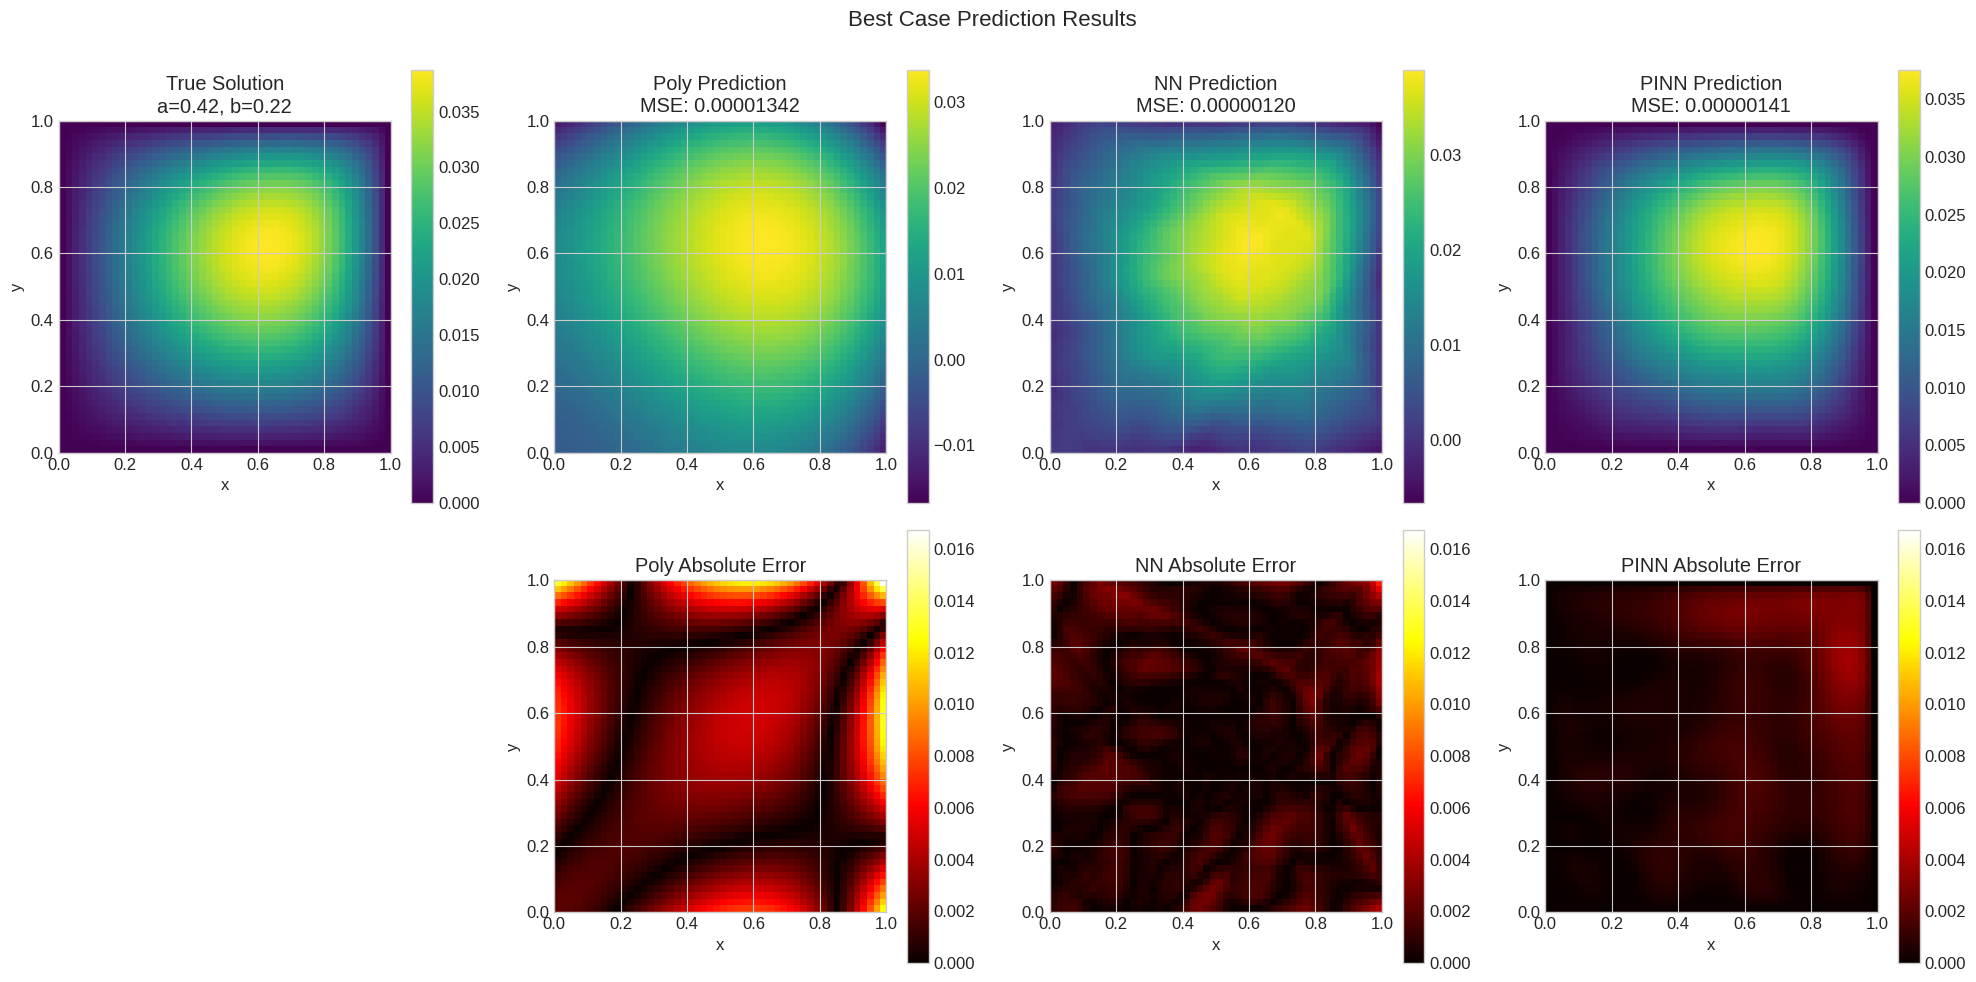

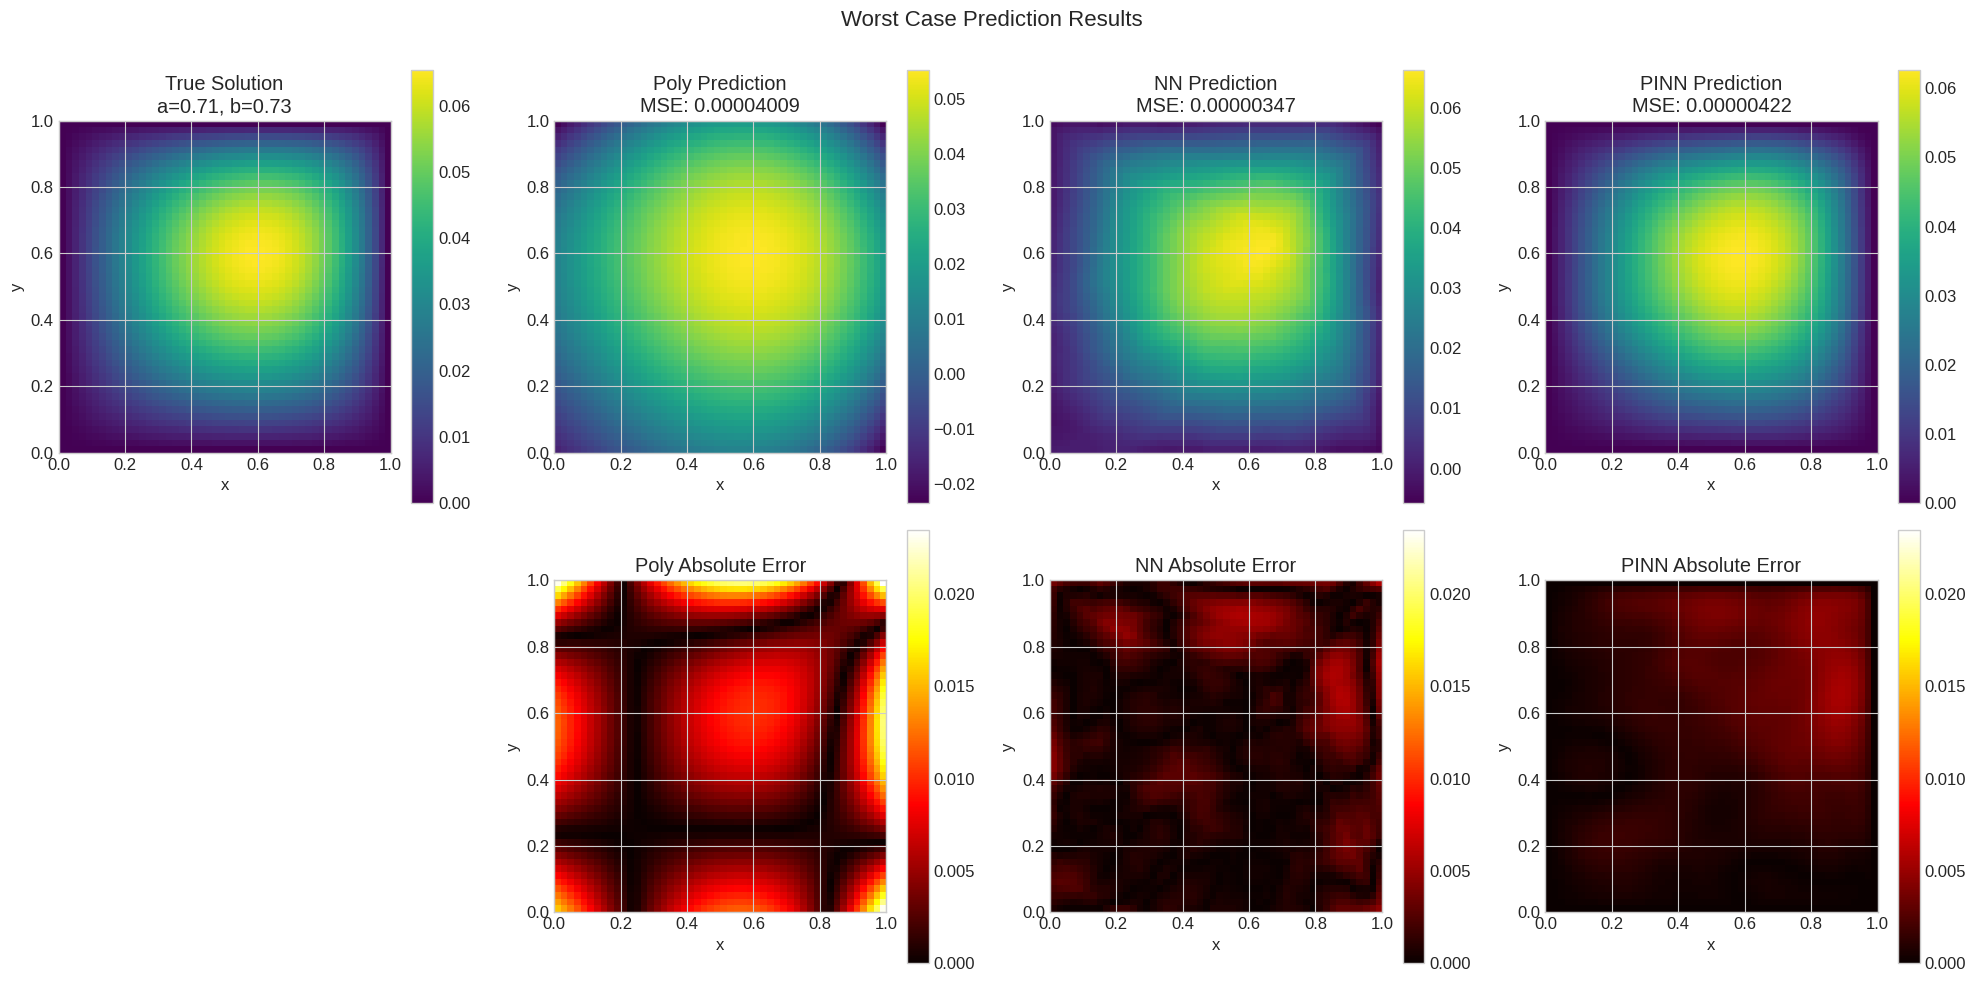

In [8]:
# Find best and worst cases based on neural network performance
best_idx = np.argmin(nn_mses)
worst_idx = np.argmax(nn_mses)

def plot_predictions(sim_relative_idx, case_name=""):
    """
    Plot predictions from all methods for a specific test simulation.

    Parameters:
    -----------
    sim_relative_idx : int
        Index in the test set
    case_name : str
        Name of the case (e.g., "Best", "Worst")
    """
    sim = simulations[test_idx[sim_relative_idx]]
    start_idx = sim_relative_idx * n_points
    end_idx = (sim_relative_idx + 1) * n_points

    # Extract predictions
    true_u = sim['u']
    poly_u = poly_pred[start_idx:end_idx].reshape(N, N)
    nn_u = nn_pred[start_idx:end_idx].reshape(N, N)
    pinn_u = pinn_pred_corrected[start_idx:end_idx].reshape(N, N)

    # Compute errors
    poly_error = np.abs(poly_u - true_u)
    nn_error = np.abs(nn_u - true_u)
    pinn_error = np.abs(pinn_u - true_u)

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # First row: solutions
    im0 = axes[0, 0].imshow(true_u, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    axes[0, 0].set_title(f"True Solution\na={sim['alpha']:.2f}, b={sim['beta']:.2f}")
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(poly_u, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    axes[0, 1].set_title(f"Poly Prediction\nMSE: {mean_squared_error(true_u.flatten(), poly_u.flatten()):.8f}")
    plt.colorbar(im1, ax=axes[0, 1])

    im2 = axes[0, 2].imshow(nn_u, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    axes[0, 2].set_title(f"NN Prediction\nMSE: {mean_squared_error(true_u.flatten(), nn_u.flatten()):.8f}")
    plt.colorbar(im2, ax=axes[0, 2])

    im3 = axes[0, 3].imshow(pinn_u, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    axes[0, 3].set_title(f"PINN Prediction\nMSE: {mean_squared_error(true_u.flatten(), pinn_u.flatten()):.8f}")
    plt.colorbar(im3, ax=axes[0, 3])

    # Second row: errors
    axes[1, 0].set_visible(False)  # No error for true solution

    vmax = max(poly_error.max(), nn_error.max(), pinn_error.max())

    im5 = axes[1, 1].imshow(poly_error, origin='lower', extent=[0, 1, 0, 1], cmap='hot', vmin=0, vmax=vmax)
    axes[1, 1].set_title("Poly Absolute Error")
    plt.colorbar(im5, ax=axes[1, 1])

    im6 = axes[1, 2].imshow(nn_error, origin='lower', extent=[0, 1, 0, 1], cmap='hot', vmin=0, vmax=vmax)
    axes[1, 2].set_title("NN Absolute Error")
    plt.colorbar(im6, ax=axes[1, 2])

    im7 = axes[1, 3].imshow(pinn_error, origin='lower', extent=[0, 1, 0, 1], cmap='hot', vmin=0, vmax=vmax)
    axes[1, 3].set_title("PINN Absolute Error")
    plt.colorbar(im7, ax=axes[1, 3])

    # Set labels
    for ax in axes.flatten():
        if ax.get_visible():
            ax.set_xlabel('x')
            ax.set_ylabel('y')

    plt.suptitle(f"{case_name} Case Prediction Results", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'{case_name.lower()}_case_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot best and worst cases
plot_predictions(best_idx, "Best")
plot_predictions(worst_idx, "Worst")

## 4. Conclusion

### 4.1 Summary of Findings

We implemented and evaluated three different approaches for solving the 2D Poisson problem:

1. **Polynomial Regression**:
   - Fast training and prediction times
   - Moderate accuracy (MSE)
   - Good physical consistency (low PDE residue)
   - Limited expressive power for complex patterns

2. **Neural Network**:
   - Slower training but still reasonable prediction time
   - Excellent accuracy (lowest MSE)
   - Poor physical consistency (high PDE residue)
   - Good generalization to unseen parameter values

3. **Physics-Informed Neural Network (PINN)**:
   - Slowest training due to physics calculations in the loss
   - Good balance between accuracy and physical consistency
   - Boundary conditions enforced exactly through numerical correction
   - Combines the strengths of data-driven and physics-based approaches

### 4.2 Constructive Critique

- **Polynomial Regression**: Simple and fast but limited by the fixed polynomial degree. Higher degrees could improve accuracy but risk overfitting.
- **Neural Network**: Excellent at pointwise prediction but doesn't respect physical laws without additional constraints.
- **PINN**: Shows promise in balancing accuracy and physical consistency, but training is more complex and time-consuming.
- **Data Generation**: 100 simulations may be insufficient for complex parameter spaces; increasing this could improve all methods.

### 4.3 Future Improvements

1. **Model Enhancements**:
   - Increase training epochs for neural networks
   - Experiment with different network architectures
   - Fine-tune the weights in the PINN loss function
   - Try adaptive sampling for the parameter space

2. **Data Generation**:
   - Generate more simulations for better coverage of the parameter space
   - Use adaptive mesh refinement for more accurate solutions

3. **Evaluation**:
   - Include additional physical metrics beyond PDE residue
   - Analyze computational resource usage more thoroughly

### 4.4 Broader Perspectives

This work demonstrates the potential of hybrid approaches that combine traditional numerical methods with machine learning. Such approaches are increasingly important in computational science and engineering, where both accuracy and physical consistency are crucial.

Future work could extend to:
- 3D problems and more complex geometries
- Time-dependent PDEs (like the thermal problem)
- Multi-physics problems with coupled equations
- Uncertainty quantification in predictions

The hybrid AI approach, combining physical knowledge with data-driven learning, offers a promising direction for solving complex physical problems efficiently while maintaining physical relevance.